#Importing

In [1]:
#@title
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

from keras.utils.np_utils import to_categorical
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn import svm, datasets

import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import re
import matplotlib.pyplot as plt

from keras.models import load_model

from gensim.models import KeyedVectors

import pickle
from wordcloud import WordCloud
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset: https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification

In [3]:
#@title
df = pd.read_csv("/content/drive/MyDrive/Mobile Price Classification/Dataset/MobilePriceClassificationtrain.csv")

In [4]:
#@title
df.columns

Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'price_range'],
      dtype='object')

In [5]:
#@title
df['px_width']

0        756
1       1988
2       1716
3       1786
4       1212
        ... 
1995    1890
1996    1965
1997    1632
1998     670
1999     754
Name: px_width, Length: 2000, dtype: int64

In [6]:
#@title
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


#EDA

In [7]:
#@title
df["price_range"].value_counts()

1    500
2    500
3    500
0    500
Name: price_range, dtype: int64

In [8]:
#@title
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [9]:
#@title
df.isnull().sum()

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

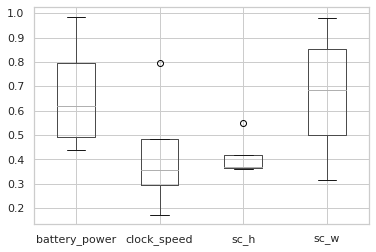

In [10]:
dfs = pd.DataFrame(data = np.random.random(size=(4,4)), columns = ['battery_power','clock_speed','sc_h','sc_w'])
dfs.boxplot()

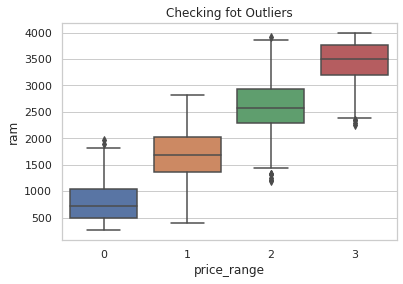

In [11]:
plt.title("Checking fot Outliers")
sns.boxplot(x='price_range' , y='ram', data=df)

In [12]:
#sns.countplot(x='price_range', data=df, palette='RdBu')
#plt.show

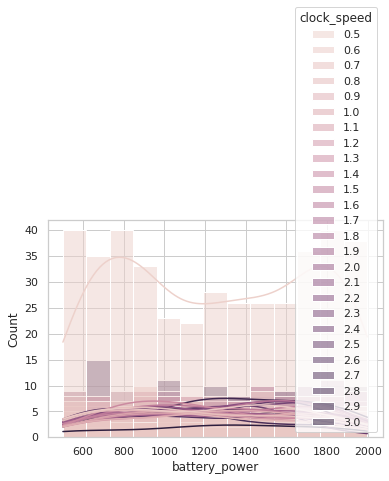

In [13]:
fig = plt.figure()
#ax = plt.axes()  
ax = sns.histplot(data = df, 
                   x='battery_power', 
                   hue = 'clock_speed', 
                   kde = 'True')
#ax1 = sns.histplot(data = df, x='battery_power')
plt.show() 

In [14]:
#vis = df.groupby('price_range').mean()

In [15]:
x = df.loc[:, df.columns != 'price_range']
y = df["price_range"]

In [16]:
# splitting X and y into training and testing sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    random_state=1)

#Support Vector Machine (Polynomial Kernel)

source: https://www.baeldung.com/cs/svm-multiclass-classification

In [17]:
rbf = svm.SVC(kernel='rbf', gamma=0.5, C=0.1).fit(x_train, y_train)
poly = svm.SVC(kernel='poly', degree=3, C=1).fit(x_train, y_train)

In [18]:
poly_pred = poly.predict(x_test)
rbf_pred = rbf.predict(x_test)

In [19]:
poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

Accuracy (Polynomial Kernel):  95.75
F1 (Polynomial Kernel):  95.75


In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test, poly_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        92
           1       0.95      0.94      0.94        96
           2       0.93      0.95      0.94       106
           3       1.00      0.94      0.97       106

    accuracy                           0.96       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400



#Support Vector Machine (RBF Kernel)

In [21]:
# splitting X and y into training and testing sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    random_state=1)

In [22]:
rbf_accuracy = accuracy_score(y_test, rbf_pred)
rbf_f1 = f1_score(y_test, rbf_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

Accuracy (RBF Kernel):  23.00
F1 (RBF Kernel):  8.60


In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_test, rbf_pred))

              precision    recall  f1-score   support

           0       0.23      1.00      0.37        92
           1       0.00      0.00      0.00        96
           2       0.00      0.00      0.00       106
           3       0.00      0.00      0.00       106

    accuracy                           0.23       400
   macro avg       0.06      0.25      0.09       400
weighted avg       0.05      0.23      0.09       400



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Logistic Regression

source: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

In [24]:
#@title
#Feature Scaling  
from sklearn.preprocessing import StandardScaler    
st_x= StandardScaler()    
x_train= st_x.fit_transform(x_train)    
x_test= st_x.transform(x_test)  

In [25]:
#@title
#Fitting Logistic Regression to the training set  
from sklearn.linear_model import LogisticRegression  
classifier= LogisticRegression(random_state=0)  
classifier.fit(x_train, y_train)  

LogisticRegression(random_state=0)

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [27]:
#Predicting the test set result  
y_pred= classifier.predict(x_test)  

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [28]:
y_pred = logreg.predict(x_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x_test, y_test)*100)+"%")

Accuracy of logistic regression classifier on test set: 64.50%


In [29]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[84 10  1  0]
 [16 53 19  4]
 [ 0 29 43 27]
 [ 0  2 34 78]]


In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86        95
           1       0.56      0.58      0.57        92
           2       0.44      0.43      0.44        99
           3       0.72      0.68      0.70       114

    accuracy                           0.65       400
   macro avg       0.64      0.64      0.64       400
weighted avg       0.64      0.65      0.64       400



#Long Short-Term Memory